# Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# drive.flush_and_unmount()

Mounted at /content/drive


# Install

In [ ]:
!pip install torch transformers pandas gensim scikit-learn advertools bnlp_toolkit Bangla-Stemmer

# Preprocessing

In [ ]:
from bnlp import CleanText
from bnlp import BengaliCorpus as corpus
from bangla_stemmer.stemmer import stemmer
import advertools as adv

stemmer = stemmer.BanglaStemmer()

def stemming(text):
    tokens = text.split()

    # Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove extra whitespace and join tokens back to text
    preprocessed_text = ' '.join(tokens).strip()
    return preprocessed_text


def remove_stopwords(text):
    stopwords = adv.stopwords['bengali']
    stopwords.update(set(corpus.stopwords))

    # Convert the text to lowercase and split it into words
    words = text.split()
    # Remove stopwords
    filtered_words = [word for word in words if word not in stopwords]
    # Reconstruct the text
    filtered_text = ' '.join(filtered_words)
    return filtered_text


def preprocess(text):

  clean_text = CleanText(
    fix_unicode=True,
    unicode_norm=True,
    unicode_norm_form="NFKC",
    remove_url=True,
    remove_email=True,
    remove_emoji=True,
    remove_number=True,
    remove_digits=True,
    remove_punct=True,
    replace_with_url="",
    replace_with_email="",
    replace_with_number="",
    replace_with_digit="",
    replace_with_punct = ""
  )
  text = clean_text(text)

  text = remove_stopwords(text)

  text = stemming(text)

  return text

text = "স্বাধীনতা তুমি, ফসলের মাঠে কৃষকের হাসি। স্বাধীনতা তুমি, রোদেলা দুপুরে মধ্যপুকুরে গ্রাম্য মেয়ের অবাধ সাঁতার।"
text = """
তবু এই দেয়ালের শরীরে
যত ছেঁড়া রং, ধুয়ে যাওয়া মানুষ
পেশাদার প্রতিহিংসা তোমার চেতনার
যত উদ্ভাসিত আলো রং
আকাশের মতন অকস্মাৎ নীল
নীলে ডুবে থাকা তোমার প্রিয় কোনো মুখ
তার চোখের কাছাকাছি এসে কেন পথ ভেঙে
"""
print(preprocess(text))


applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
দেয়াল শরীরে ছেঁড়া রং ধুয়ে পেশ প্রতিহিংসা চেতন উদ্ভাসিত আলো রং আকাশ মতন অকস্মাৎ নীল নীলে ডুবে প্রিয় মুখ চোখ কাছাকা পথ ভাঙ


In [ ]:
bangla_sarcasm_file = '/content/drive/MyDrive/Dataset4/Ben-Sarc/Ben-Sarc_ Bengali Sarcasm Detection Corpus.xlsx'
data = pd.read_excel(bangla_sarcasm_file)
len(data)

25636

In [ ]:
# Collect rows in a list
rows = []

# Iterate over the rows of the DataFrame
for index, row in data.iterrows():
    processed_text = preprocess(row['Text'])
    rows.append({'Text': processed_text, 'Sarcasm': row['Polarity']})

# Create the DataFrame from the list of rows
df = pd.DataFrame(rows)

# Display the first few rows of the new DataFrame
print(df.head())

In [ ]:
# Save to Excel
excel_file_path = '/content/gdrive/MyDrive/Dataset4/preprocessed/Processed_BanglaSarcasm.xlsx'  # Replace with your file path
df.to_excel(excel_file_path, index=False)

english

In [ ]:
import pandas as pd

import spacy
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    preprocessed_text = " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])
    return preprocessed_text


# Load data
English_sarcasm_file = '/content/drive/MyDrive/Dataset4/News-Headlines-Dataset-For-Sarcasm-Detection/Sarcasm_Headlines_Dataset.json'  # Replace with your file path
data = pd.read_json(English_sarcasm_file, lines=True)

# Collect rows in a list
rows = []

# Iterate over the rows of the DataFrame
for index, row in data.iterrows():
    processed_text = preprocess(row['headline'])
    rows.append({'Text': processed_text, 'Sarcasm': row['is_sarcastic']})

# Create the DataFrame from the list of rows
df = pd.DataFrame(rows)

# Save to Excel
excel_file_path = '/content/gdrive/MyDrive/Dataset4/preprocessed/Processed_EnglishSarcasm.xlsx'  # Replace with your file path
df.to_excel(excel_file_path, index=False)

# Display the first few rows of the new DataFrame
print(df.head())


# Embeddings

mBERT

In [ ]:
# Install necessary libraries
!pip install transformers torch numpy

import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
import os

# Load the dataframe
# preprocessed_file_path = '/content/drive/MyDrive/Dataset4/preprocessed/Processed_BanglaSarcasm.xlsx'
preprocessed_file_path = '/content/drive/MyDrive/Dataset4/preprocessed/Processed_EnglishSarcasm.xlsx'
df = pd.read_excel(preprocessed_file_path)
df = df.dropna(subset=['Text'])


# Location to save the numpy array
# loc = '/content/drive/MyDrive/Dataset4/tfidf/embeddings_sarcasm.npy'
loc = '/content/drive/MyDrive/Dataset4/tfidf/embeddings_sarcasm_english.npy'

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# Batch size
batch_size = 100

# Initialize an empty numpy array if the file doesn't exist
if not os.path.exists(loc):
    np.save(loc, np.empty((0, 768)))

# Process texts in batches
for start_idx in range(0, len(df), batch_size):
    end_idx = min(start_idx + batch_size, len(df))
    texts_batch = df['Text'][start_idx:end_idx]

    # Tokenize and encode the texts
    encodings = tokenizer(list(texts_batch), truncation=True, padding=True, max_length=128, return_tensors='pt')

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**encodings)
        embeddings_batch = outputs.last_hidden_state.mean(dim=1).numpy()  # Get mean of the last hidden states

    # Load the existing embeddings
    existing_embeddings = np.load(loc)

    # Append the new embeddings
    updated_embeddings = np.vstack((existing_embeddings, embeddings_batch))

    # Save the updated embeddings
    np.save(loc, updated_embeddings)

    # Print progress
    print(f"{end_idx} data rows have been processed and saved so far.")

print(f"All data rows have been processed and saved to {loc}")


XLM-RoBERTa

In [ ]:
# Install necessary libraries
!pip install transformers torch numpy

import pandas as pd
import numpy as np
from transformers import XLMRobertaTokenizer, XLMRobertaModel
import torch
import os



preprocessed_file_paths = ['/content/drive/MyDrive/Dataset4/preprocessed/Processed_BanglaSarcasm.xlsx', '/content/drive/MyDrive/Dataset4/preprocessed/Processed_EnglishSarcasm.xlsx']
locs = ['/content/drive/MyDrive/Dataset4/tfidf/xlm_embeddings_sarcasm_bangla.npy', '/content/drive/MyDrive/Dataset4/tfidf/xlm_embeddings_sarcasm_english.npy']

for preprocessed_file_path, loc in zip(preprocessed_file_paths, locs):
    # Load the dataframe
    df = pd.read_excel(preprocessed_file_path)
    df = df.dropna(subset=['Text'])

    # Location to save the numpy array

    # Load the tokenizer and model
    tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
    model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

    # Batch size
    batch_size = 100

    # Initialize an empty numpy array if the file doesn't exist
    if not os.path.exists(loc):
        np.save(loc, np.empty((0, 768)))

    # Process texts in batches
    for start_idx in range(0, len(df), batch_size):
        end_idx = min(start_idx + batch_size, len(df))
        texts_batch = df['Text'][start_idx:end_idx]

        # Tokenize and encode the texts
        encodings = tokenizer(list(texts_batch), truncation=True, padding=True, max_length=128, return_tensors='pt')

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**encodings)
            embeddings_batch = outputs.last_hidden_state.mean(dim=1).numpy()  # Get mean of the last hidden states

        # Load the existing embeddings
        existing_embeddings = np.load(loc)

        # Append the new embeddings
        updated_embeddings = np.vstack((existing_embeddings, embeddings_batch))

        # Save the updated embeddings
        np.save(loc, updated_embeddings)

        # Print progress
        print(f"{end_idx} data rows have been processed and saved so far.")

    print(f"All data rows have been processed and saved to {loc}")


mT5

In [ ]:
# # Install necessary libraries
# !pip install transformers torch numpy

import pandas as pd
import numpy as np
from transformers import T5Tokenizer, T5EncoderModel
import torch
import os

preprocessed_file_paths = ['/content/drive/MyDrive/Dataset4/preprocessed/Processed_EnglishSarcasm.xlsx',
                           '/content/drive/MyDrive/Dataset4/preprocessed/Processed_BanglaSarcasm.xlsx'
                           ]
locs = ['/content/drive/MyDrive/Dataset4/tfidf/mt5xxl_embeddings_sarcasm_english.npy',
        '/content/drive/MyDrive/Dataset4/tfidf/mt5xxl_embeddings_sarcasm_bangla.npy'
        ]

# Use mT5-xxl for larger performance
tokenizer = T5Tokenizer.from_pretrained('google/mt5-xl')
model = T5EncoderModel.from_pretrained('google/mt5-xl')

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Batch size
batch_size = 100

for preprocessed_file_path, loc in zip(preprocessed_file_paths, locs):
    # Load the dataframe
    df = pd.read_excel(preprocessed_file_path)
    df = df.dropna(subset=['Text'])

    # Check if the embeddings file exists
    if not os.path.exists(loc):
        print("SAVING______________________________")
        # Initialize an empty numpy array for new embeddings
        np.save(loc, np.empty((0, model.config.d_model)))  # Using model config for embedding size
        start_idx = 0  # Start from the beginning if file doesn't exist
    else:
        # Load the existing embeddings to continue from the last point
        existing_embeddings = np.load(loc)
        start_idx = len(existing_embeddings)  # Determine the starting index
        print(f"Resuming from index {start_idx}...")

    # Process texts in batches, starting from where we left off
    for start_batch_idx in range(start_idx, len(df), batch_size):
        end_idx = min(start_batch_idx + batch_size, len(df))
        texts_batch = df['Text'][start_batch_idx:end_idx]

        # Tokenize and encode the texts
        encodings = tokenizer(list(texts_batch), truncation=True, padding=True, max_length=128, return_tensors='pt')
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        # Generate embeddings
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings_batch = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Move to CPU before converting to numpy

        # Load the existing embeddings
        existing_embeddings = np.load(loc)

        # Append the new embeddings
        updated_embeddings = np.vstack((existing_embeddings, embeddings_batch))

        # Save the updated embeddings
        np.save(loc, updated_embeddings)

        # Print progress
        print(f"{end_idx} data rows have been processed and saved so far.")

    print(f"All data rows have been processed and saved to {loc}")


# SVM

In [ ]:
from sklearn.svm import SVC

def svm(x_train, x_test, y_train, y_test):
    # Generate the model
    model = SVC(kernel='linear', C=1.5, probability=True)

    # Train the model
    model.fit(x_train, y_train)

    # Predict the test set
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]  # Probability estimates for positive class

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    # Print the results
    print("Classifier: SVM")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

# Example usage (Replace x_train, x_test, y_train, y_test with your data)
# svm(x_train, x_test, y_train, y_test)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def svm2(x_train, x_test, y_train, y_test):
    # Generate the model with an RBF kernel
    model = SVC(kernel='rbf', C=1, gamma='scale', probability=True)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Classifier: SVM (RBF Kernel)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


# RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def rf(x_train, x_test, y_train, y_test):

    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    model.fit(x_train, y_train)

    # Predict the test set
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]  # Probability estimates for positive class

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    print("Classifier: Random Forest")
    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def rf2(x_train, x_test, y_train, y_test):
    # Generate the model with tuned hyperparameters
    model = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5,
                                   min_samples_leaf=2, random_state=42, n_jobs=-1)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Classifier: Random Forest (Tuned)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


# MNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

def mnb_with_extended_grid_search(x_train, x_test, y_train, y_test):
    # Scaling the embeddings to be non-negative
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define the Multinomial Naive Bayes classifier
    model = MultinomialNB()

    # Define the extended parameter grid
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],  # Different alpha values to try
        'fit_prior': [True, False]  # Whether to learn class prior probabilities
        # You can also add 'class_prior' if you have specific class priors to try
    }

    # Set up Grid Search with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
    grid_search.fit(x_train_scaled, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predict the labels for the test set
    y_pred = best_model.predict(x_test_scaled)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the results
    print("Best Model Parameters:", grid_search.best_params_)
    print(f"Classifier: Multinomial Naive Bayes with alpha={grid_search.best_params_['alpha']}, fit_prior={grid_search.best_params_['fit_prior']}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Example usage
# mnb_with_extended_grid_search(x_train, x_test, y_train, y_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

def mnb_with_grid_search(x_train, x_test, y_train, y_test):
    # Scaling the embeddings to be non-negative
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define the Multinomial Naive Bayes classifier
    model = MultinomialNB()

    # Define the parameter grid
    param_grid = {
        'alpha': [1.0, 1.5, 2.0, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]  # Different alpha values to try
    }

    # Set up Grid Search with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted')
    grid_search.fit(x_train_scaled, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predict the labels for the test set
    y_pred = best_model.predict(x_test_scaled)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the results
    print("Best Model Parameters:", grid_search.best_params_)
    print(f"Classifier: Multinomial Naive Bayes with alpha={grid_search.best_params_['alpha']}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Example usage
# mnb_with_grid_search(x_train, x_test, y_train, y_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def mnb(x_train, x_test, y_train, y_test):
    # Scaling the embeddings to be non-negative
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define the Multinomial Naive Bayes classifier
    model = MultinomialNB()

    # Train the model
    model.fit(x_train_scaled, y_train)

    # Predict the labels for the test set
    y_pred = model.predict(x_test_scaled)

    y_proba = model.predict_proba(x_test)[:, 1]  # Probability estimates for positive class

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    # Print the results
    print("Classifier: Multinomial Naive Bayes")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

# Example usage
# multinomial_nb(x_train, x_test, y_train, y_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def mnb1(x_train, x_test, y_train, y_test):
    # Scaling the embeddings to be non-negative
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define the Multinomial Naive Bayes classifier
    model = MultinomialNB(alpha=0.75)

    # Train the model
    model.fit(x_train_scaled, y_train)

    # Predict the labels for the test set
    y_pred = model.predict(x_test_scaled)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the results
    print("Classifier: Multinomial Naive Bayes")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Example usage
# multinomial_nb(x_train, x_test, y_train, y_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def mnb2(x_train, x_test, y_train, y_test):
    # Scaling the embeddings to be non-negative
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define the Multinomial Naive Bayes classifier
    model = MultinomialNB(alpha=1.0)

    # Train the model
    model.fit(x_train_scaled, y_train)

    # Predict the labels for the test set
    y_pred = model.predict(x_test_scaled)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the results
    print("Classifier: Multinomial Naive Bayes")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Example usage
# multinomial_nb(x_train, x_test, y_train, y_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def mnb3(x_train, x_test, y_train, y_test):
    # Scaling the embeddings to be non-negative
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define the Multinomial Naive Bayes classifier
    model = MultinomialNB(alpha=1.25)

    # Train the model
    model.fit(x_train_scaled, y_train)

    # Predict the labels for the test set
    y_pred = model.predict(x_test_scaled)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the results
    print("Classifier: Multinomial Naive Bayes")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Example usage
# multinomial_nb(x_train, x_test, y_train, y_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def mnb4(x_train, x_test, y_train, y_test):
    # Scaling the embeddings to be non-negative
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Define the Multinomial Naive Bayes classifier
    model = MultinomialNB(alpha=1.5)

    # Train the model
    model.fit(x_train_scaled, y_train)

    # Predict the labels for the test set
    y_pred = model.predict(x_test_scaled)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the results
    print("Classifier: Multinomial Naive Bayes")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Example usage
# multinomial_nb(x_train, x_test, y_train, y_test)


# LR

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def lr(x_train, x_test, y_train, y_test):
    # Define the Logistic Regression classifier
    model = LogisticRegression(max_iter=1000, random_state=42)

    # Train the model
    model.fit(x_train, y_train)

    # Predict the test set
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]  # Probability estimates for positive class

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)



    # Print the results
    print("Classifier: Logistic Regression")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

# Example usage
# logistic_regression(x_train, x_test, y_train, y_test)


# DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def dt(x_train, x_test, y_train, y_test):
    # Define the Decision Tree classifier
    model = DecisionTreeClassifier(max_depth=10, random_state=42)

    # Train the model
    model.fit(x_train, y_train)

    # Predict the test set
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]  # Probability estimates for positive class

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    # Print the results
    print("Classifier: Decision Tree")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")
# Example usage
# decision_tree(x_train, x_test, y_train, y_test)


# knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def knn(x_train, x_test, y_train, y_test):
    # Define the KNN classifier
    model = KNeighborsClassifier(n_neighbors=5)  # Using 5 neighbors as default

    # Train the model
    model.fit(x_train, y_train)

    # Predict class labels
    y_pred = model.predict(x_test)

    # Predict probability estimates for the positive class
    y_proba = model.predict_proba(x_test)[:, 1]

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    # Print the results
    print("Classifier: K-Nearest Neighbors")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

# Example usage (Replace x_train, x_test, y_train, y_test with your data)
# knn_classifier(x_train, x_test, y_train, y_test)


# LSTM

In [ ]:
def lstm1(x_train, x_test, y_train, y_test):

    feature_number = x_train.shape[1]
    # Reshape the input data
    x_train = x_train.reshape((x_train.shape[0], 1, feature_number))
    x_test = x_test.reshape((x_test.shape[0], 1, feature_number))


    inputs = tf.keras.Input(shape=(1, feature_number))
    lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
    lstm = tf.keras.layers.LSTM(64)(lstm)
    lstm = tf.keras.layers.Dropout(0.1)(lstm)
    # lstm = tf.keras.layers.Dense(512, activation='relu')(lstm)
    # lstm = tf.keras.layers.Dense(512, activation='relu')(lstm)
    # lstm = tf.keras.layers.Dense(256, activation='softmax')(lstm)
    # lstm = tf.keras.layers.Dense(256, activation='softmax')(lstm)
    lstm = tf.keras.layers.Reshape((1, 64))(lstm)
    lstm = tf.keras.layers.Dropout(0.1)(lstm)
    lstm = tf.keras.layers.LSTM(64, activation='relu')(lstm)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(lstm)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(x=x_train, y=y_train, batch_size=64, epochs=700, validation_split=0.3, callbacks=[early_stop])

    test_results = model.evaluate(x=x_test, y=y_test)
    model.save('lstm1.h5')

    # Predict and calculate metrics using sklearn
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Classifier: LSTM")
    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

In [ ]:
def lstm2(x_train, x_test, y_train, y_test):

    feature_number = x_train.shape[1]
    # Reshape the input data
    x_train = x_train.reshape((x_train.shape[0], 1, feature_number))
    x_test = x_test.reshape((x_test.shape[0], 1, feature_number))


    inputs = tf.keras.Input(shape=(1, feature_number))
    lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
    lstm = tf.keras.layers.LSTM(64)(lstm)
    lstm = tf.keras.layers.Dropout(0.1)(lstm)
    lstm = tf.keras.layers.Reshape((1, 64))(lstm)
    lstm = tf.keras.layers.Dropout(0.1)(lstm)
    lstm = tf.keras.layers.LSTM(64, activation='relu')(lstm)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(lstm)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(x=x_train, y=y_train, batch_size=64, epochs=500, validation_split=0.3, callbacks=[early_stop])

    # Evaluate the model on test data
    test_results = model.evaluate(x=x_test, y=y_test)

    # Predict and calculate metrics using sklearn
    y_proba = model.predict(x_test).ravel()
    y_pred = (y_proba > 0.5).astype("int32")

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    # Print the results
    print("Classifier: LSTM")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def lstm3(x_train, x_test, y_train, y_test):
    feature_number = x_train.shape[1]
    # Reshape the input data
    x_train = x_train.reshape((x_train.shape[0], 1, feature_number))
    x_test = x_test.reshape((x_test.shape[0], 1, feature_number))

    # Define the LSTM model
    inputs = tf.keras.Input(shape=(1, feature_number))
    lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
    lstm = tf.keras.layers.LSTM(64)(lstm)
    lstm = tf.keras.layers.Dropout(0.3)(lstm)
    lstm = tf.keras.layers.Reshape((1, 64))(lstm)
    lstm = tf.keras.layers.LSTM(64)(lstm)


    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(lstm)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

    # Set up early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(x=x_train, y=y_train, batch_size=64, epochs=300, validation_split=0.3, callbacks=[early_stop])

    # Evaluate the model
    test_results = model.evaluate(x=x_test, y=y_test)
    model.save('lstm2.h5')

    # Predict and calculate metrics using sklearn
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Classifier: LSTM")
    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def lstm4(x_train, x_test, y_train, y_test):
    feature_number = x_train.shape[1]
    # Reshape the input data
    x_train = x_train.reshape((x_train.shape[0], 1, feature_number))
    x_test = x_test.reshape((x_test.shape[0], 1, feature_number))

    # Define the LSTM model
    inputs = tf.keras.Input(shape=(1, feature_number))
    lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
    lstm = tf.keras.layers.LSTM(64)(lstm)
    lstm = tf.keras.layers.Dropout(0.3)(lstm)
    lstm = tf.keras.layers.Reshape((1, 64))(lstm)
    lstm = tf.keras.layers.LSTM(64)(lstm)


    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(lstm)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

    # Set up early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(x=x_train, y=y_train, batch_size=128, epochs=300, validation_split=0.3, callbacks=[early_stop])

    # Evaluate the model
    test_results = model.evaluate(x=x_test, y=y_test)
    model.save('lstm2.h5')

    # Predict and calculate metrics using sklearn
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Classifier: LSTM")
    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


# BiLSTM

In [ ]:
def bilstm1(x_train, x_test, y_train, y_test):

    feature_number = x_train.shape[1]
    # Reshape the input data
    x_train = x_train.reshape((x_train.shape[0], 1, feature_number))
    x_test = x_test.reshape((x_test.shape[0], 1, feature_number))


    inputs = tf.keras.Input(shape=(1, feature_number))
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs)
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))(bilstm)
    bilstm = tf.keras.layers.Dropout(0.1)(bilstm)
    bilstm = tf.keras.layers.Dense(512, activation='relu')(bilstm)
    bilstm = tf.keras.layers.Dense(256, activation='softmax')(bilstm)
    bilstm = tf.keras.layers.Reshape((1, 256))(bilstm)
    bilstm = tf.keras.layers.Dropout(0.1)(bilstm)
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='relu'))(bilstm)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(bilstm)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(x=x_train, y=y_train, batch_size=256, epochs=900, validation_split=0.3, callbacks=[early_stop])

    # Evaluate the model on test data
    test_results = model.evaluate(x=x_test, y=y_test)

    # Predict and calculate metrics using sklearn
    y_proba = model.predict(x_test).ravel()
    y_pred = (y_proba > 0.5).astype("int32")

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    # Print the results
    print("Classifier: LSTM")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

In [ ]:
def bilstm2(x_train, x_test, y_train, y_test):

    feature_number = x_train.shape[1]
    # Reshape the input data
    x_train = x_train.reshape((x_train.shape[0], 1, feature_number))
    x_test = x_test.reshape((x_test.shape[0], 1, feature_number))


    inputs = tf.keras.Input(shape=(1, feature_number))
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(inputs)
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(bilstm)
    bilstm = tf.keras.layers.Dropout(0.1)(bilstm)
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(bilstm)

    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu'))(bilstm)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(bilstm)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(x=x_train, y=y_train, batch_size=64, epochs=500, validation_split=0.3, callbacks=[early_stop])

    # Evaluate the model on test data
    test_results = model.evaluate(x=x_test, y=y_test)

    # Predict and calculate metrics using sklearn
    y_proba = model.predict(x_test).ravel()
    y_pred = (y_proba > 0.5).astype("int32")

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    # Print the results
    print("Classifier: BiLSTM")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def bilstm3(x_train, x_test, y_train, y_test):
    feature_number = x_train.shape[1]
    # Reshape the input data
    x_train = x_train.reshape((x_train.shape[0], 1, feature_number))
    x_test = x_test.reshape((x_test.shape[0], 1, feature_number))

    # Define the BiLSTM model
    inputs = tf.keras.Input(shape=(1, feature_number))
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(inputs)
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(bilstm)
    # bilstm = tf.keras.layers.Dropout(0.1)(bilstm)
    # bilstm = tf.keras.layers.Reshape((1, 64))(bilstm)
    # bilstm = tf.keras.layers.Dropout(0.1)(bilstm)
    bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu'))(bilstm)
    bilstm = tf.keras.layers.Dropout(0.1)(bilstm)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(bilstm)



    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(bilstm)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

    # Set up early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(x=x_train, y=y_train, batch_size=64, epochs=300, validation_split=0.3, callbacks=[early_stop])

    # Evaluate the model
    test_results = model.evaluate(x=x_test, y=y_test)
    model.save('bilstm2.h5')

    # Predict and calculate metrics using sklearn
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Classifier: BiLSTM")
    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")


# XGBoost

In [ ]:
import xgboost as xgb
def xgboost(x_train, x_test, y_train, y_test):
    model = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=7,
        learning_rate=0.1,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    )

    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=True)

    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Classifier: XGBoost Classifier")
    # Print the overall results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def xgboost2(x_train, x_test, y_train, y_test):
    # Define the XGBoost classifier
    model = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.1,
        objective='binary:logistic',
        use_label_encoder=False,
        early_stopping_rounds=10,
        eval_metric='logloss'
    )

    # Train the model with early stopping
    model.fit(
        x_train,
        y_train,
        eval_set=[(x_test, y_test)],
        verbose=False
    )

    # Predict class labels
    y_pred = model.predict(x_test)

    # Predict probability estimates for the positive class
    y_proba = model.predict_proba(x_test)[:, 1]

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix and derive TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)

    # Print the results
    print("Classifier: XGBoost Classifier")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"True Negative: {tn}")
    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive: {tp}")
    print(f"AUC: {auc:.4f}")

# Example usage (Replace x_train, x_test, y_train, y_test with your data)
# xgboost2(x_train, x_test, y_train, y_test)


# Run

In [ ]:
xlmroberta = {'name': 'XLM-RoBERTa',
           'bangla': '/content/drive/MyDrive/Dataset4/tfidf/xlm_embeddings_sarcasm_bangla.npy',
           'english': '/content/drive/MyDrive/Dataset4/tfidf/xlm_embeddings_sarcasm_english.npy'}
mbert = {'name': 'mBERT',
           'bangla': '/content/drive/MyDrive/Dataset4/tfidf/mBERT_embeddings_sarcasm_bangla.npy',
           'english': '/content/drive/MyDrive/Dataset4/tfidf/mBERT_embeddings_sarcasm_english.npy'}
mt5xl = {'name': 'MT5',
           'bangla': '/content/drive/MyDrive/Dataset4/tfidf/mt5xl_embeddings_sarcasm_bangla.npy',
           'english': '/content/drive/MyDrive/Dataset4/tfidf/mt5xl_embeddings_sarcasm_english.npy'}

In [ ]:
languages = ['bangla', 'english']
embedding_list = [xlmroberta, mbert, mt5xl]

classifiers = [rf, mnb, lr, dt, knn, lstm2, bilstm2, xgboost2]
# Load the dataframe
preprocessed_file_path_bangla = '/content/drive/MyDrive/Dataset4/preprocessed/Processed_BanglaSarcasm.xlsx'
preprocessed_file_path_english = '/content/drive/MyDrive/Dataset4/preprocessed/Processed_EnglishSarcasm.xlsx'


bangla_df = pd.read_excel(preprocessed_file_path_bangla)
bangla_df = bangla_df.dropna(subset=['Text'])

english_df = pd.read_excel(preprocessed_file_path_english)
english_df = english_df.dropna(subset=['Text'])

label_list = {'bangla': np.array(bangla_df['Sarcasm'].values),
          'english': np.array(english_df['Sarcasm'].values)}

for embedding in embedding_list:
    for classifier in classifiers:

        print('===========================================================================================================================================\nPERFORMANCE\n===========================================================================================================================================')


        for language in languages:
            embeddings = np.load(embedding[language])
            labels = label_list[language]
            print(language.upper())

            x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

            print('Embeddings/N-grams: ', embedding['name'])
            classifier(x_train, x_test, y_train, y_test)





PERFORMANCE
BANGLA
Embeddings/N-grams:  MT5
Classifier: SVM
Accuracy: 0.6936
Precision: 0.6930
Recall: 0.7069
F1-score: 0.6999
True Negative: 1723
False Positive: 811
False Negative: 759
True Positive: 1831
AUC: 0.7516
ENGLISH
Embeddings/N-grams:  MT5
Classifier: SVM
Accuracy: 0.7486
Precision: 0.7404
Recall: 0.7260
F1-score: 0.7332
True Negative: 2307
False Positive: 693
False Negative: 746
True Positive: 1977
AUC: 0.8215


# Sort

In [ ]:
import pandas as pd

def parse_results(file_path, splitter):
    # Read text data from file
    with open(file_path, 'r') as file:
        text = file.read()

    # Split the text by the custom splitter string
    blocks = text.split(splitter)

    bangla_data = []
    english_data = []

    i = 0

    # Parse each block of text
    for block in blocks:
        i += 1
        lines = block.strip().splitlines()
        if len(lines) < 23:  # Ensure the block contains all needed information
            continue

        # Extract the embedding and classifier names
        embedding = lines[1].split(":")[1].strip()
        classifier = lines[2].split(":")[1].strip()
        model_name = f"{embedding} + {classifier}"

        # Extract Bangla performance metrics
        bangla_metrics = {
            'Modelname': model_name,
            'Accuracy': float(lines[3].split(":")[1].strip()),
            'Precision': float(lines[4].split(":")[1].strip()),
            'Recall': float(lines[5].split(":")[1].strip()),
            'F1-score': float(lines[6].split(":")[1].strip()),
            'True Negative': int(lines[7].split(":")[1].strip()),
            'False Positive': int(lines[8].split(":")[1].strip()),
            'False Negative': int(lines[9].split(":")[1].strip()),
            'True Positive': int(lines[10].split(":")[1].strip()),
            'AUC': float(lines[11].split(":")[1].strip())
        }
        bangla_data.append(bangla_metrics)

        # Extract English performance metrics
        english_metrics = {
            'Modelname': model_name,
            'Accuracy': float(lines[15].split(":")[1].strip()),
            'Precision': float(lines[16].split(":")[1].strip()),
            'Recall': float(lines[17].split(":")[1].strip()),
            'F1-score': float(lines[18].split(":")[1].strip()),
            'True Negative': int(lines[19].split(":")[1].strip()),
            'False Positive': int(lines[20].split(":")[1].strip()),
            'False Negative': int(lines[21].split(":")[1].strip()),
            'True Positive': int(lines[22].split(":")[1].strip()),
            'AUC': float(lines[23].split(":")[1].strip())
        }
        english_data.append(english_metrics)
        print(i, " done")

    # Create DataFrames
    bangla_df = pd.DataFrame(bangla_data)
    english_df = pd.DataFrame(english_data)

    # Save DataFrames to files
    bangla_df.to_excel('/content/drive/MyDrive/Dataset4/bangla_sarcasm_performance.xlsx', index=False)
    english_df.to_excel('/content/drive/MyDrive/Dataset4/english_sarcasm_performance.xlsx', index=False)

    print("DataFrames created and saved successfully.")


In [ ]:
# Result.txt is where classification performance (found from the `Run` cell) of each of 27 models are copy-pasted
file_path = '/content/drive/MyDrive/Result.txt'
splitter = '===========================================================================================================================================\nPERFORMANCE\n==========================================================================================================================================='

parse_results(file_path, splitter)
# print(result)

# Wilcoxon test on Accuracy

In [ ]:
# Storing the provided values in the `bng` list
bng = [
    {"embedding": "XLM-RoBERTa", "classifier": "SVM", "value": 0.718},
    {"embedding": "XLM-RoBERTa", "classifier": "Random Forest", "value": 0.6831},
    {"embedding": "XLM-RoBERTa", "classifier": "Multinomial Naive Bayes", "value": 0.5902},
    {"embedding": "XLM-RoBERTa", "classifier": "Logistic Regression", "value": 0.7131},
    {"embedding": "XLM-RoBERTa", "classifier": "Decision Tree", "value": 0.6095},
    {"embedding": "XLM-RoBERTa", "classifier": "K-Nearest Neighbours", "value": 0.6382},
    {"embedding": "XLM-RoBERTa", "classifier": "LSTM", "value": 0.7123},
    {"embedding": "XLM-RoBERTa", "classifier": "BiLSTM", "value": 0.7141},
    {"embedding": "XLM-RoBERTa", "classifier": "XGBoost Classifier", "value": 0.6911},
    {"embedding": "mBERT", "classifier": "SVM", "value": 0.6747},
    {"embedding": "mBERT", "classifier": "Random Forest", "value": 0.6579},
    {"embedding": "mBERT", "classifier": "Multinomial Naive Bayes", "value": 0.6212},
    {"embedding": "mBERT", "classifier": "Logistic Regression", "value": 0.6778},
    {"embedding": "mBERT", "classifier": "Decision Tree", "value": 0.5925},
    {"embedding": "mBERT", "classifier": "K-Nearest Neighbours", "value": 0.6311},
    {"embedding": "mBERT", "classifier": "LSTM", "value": 0.6844},
    {"embedding": "mBERT", "classifier": "BiLSTM", "value": 0.6805},
    {"embedding": "mBERT", "classifier": "XGBoost Classifier", "value": 0.6669},

    {"embedding": "mt5", "classifier": "SVM", "value": 0.6936},

    {"embedding": "mt5", "classifier": "Random Forest", "value": 0.6514},
    {"embedding": "mt5", "classifier": "Multinomial Naive Bayes", "value": 0.6007},
    {"embedding": "mt5", "classifier": "Logistic Regression", "value": 0.6924},
    {"embedding": "mt5", "classifier": "Decision Tree", "value": 0.5790},
    {"embedding": "mt5", "classifier": "K-Nearest Neighbours", "value": 0.6044},
    {"embedding": "mt5", "classifier": "LSTM", "value": 0.6924},
    {"embedding": "mt5", "classifier": "BiLSTM", "value": 0.6942},
    {"embedding": "mt5", "classifier": "XGBoost Classifier", "value": 0.6665}
]

# Storing the provided values in the `eng` list
eng = [
    {"embedding": "XLM-RoBERTa", "classifier": "SVM", "value": 0.7321},
    {"embedding": "XLM-RoBERTa", "classifier": "Random Forest", "value": 0.6839},
    {"embedding": "XLM-RoBERTa", "classifier": "Multinomial Naive Bayes", "value": 0.6472},
    {"embedding": "XLM-RoBERTa", "classifier": "Logistic Regression", "value": 0.7241},
    {"embedding": "XLM-RoBERTa", "classifier": "Decision Tree", "value": 0.6124},
    {"embedding": "XLM-RoBERTa", "classifier": "K-Nearest Neighbours", "value": 0.6525},
    {"embedding": "XLM-RoBERTa", "classifier": "LSTM", "value": 0.7341},
    {"embedding": "XLM-RoBERTa", "classifier": "BiLSTM", "value": 0.7341},
    {"embedding": "XLM-RoBERTa", "classifier": "XGBoost Classifier", "value": 0.7143},
    {"embedding": "mBERT", "classifier": "SVM", "value": 0.7169},
    {"embedding": "mBERT", "classifier": "Random Forest", "value": 0.6848},
    {"embedding": "mBERT", "classifier": "Multinomial Naive Bayes", "value": 0.6678},
    {"embedding": "mBERT", "classifier": "Logistic Regression", "value": 0.7189},
    {"embedding": "mBERT", "classifier": "Decision Tree", "value": 0.5985},
    {"embedding": "mBERT", "classifier": "K-Nearest Neighbours", "value": 0.6843},
    {"embedding": "mBERT", "classifier": "LSTM", "value": 0.7306},
    {"embedding": "mBERT", "classifier": "BiLSTM", "value": 0.719},
    {"embedding": "mBERT", "classifier": "XGBoost Classifier", "value": 0.7044},

    {"embedding": "mt5", "classifier": "SVM", "value": 0.7486},

    {"embedding": "mt5", "classifier": "Random Forest", "value": 0.6914},
    {"embedding": "mt5", "classifier": "Multinomial Naive Bayes", "value": 0.6432},
    {"embedding": "mt5", "classifier": "Logistic Regression", "value": 0.7505},
    {"embedding": "mt5", "classifier": "Decision Tree", "value": 0.6128},
    {"embedding": "mt5", "classifier": "K-Nearest Neighbours", "value": 0.6456},
    {"embedding": "mt5", "classifier": "LSTM", "value": 0.7402},
    {"embedding": "mt5", "classifier": "BiLSTM", "value": 0.7430},
    {"embedding": "mt5", "classifier": "XGBoost Classifier", "value": 0.7162}
]


In [ ]:

# List to store the difference between values
differences = []
cnt = 0;

# Loop through each dictionary in the English list
for eng_dict in eng:
    # Loop through each dictionary in the Bangla list
    for bng_dict in bng:
        # Check the conditions for subtraction
        if (eng_dict['embedding'] == bng_dict['embedding'] or
            eng_dict['classifier'] == bng_dict['classifier']):
            # if (eng_dict['embedding'] == bng_dict['embedding'] and eng_dict['classifier'] == bng_dict['classifier']): continue

            # Compute the difference
            difference = eng_dict['value'] - bng_dict['value']
            # Append the difference to the list
            # print(f"English <{eng_dict['embedding']}+{eng_dict['classifier']}>  -  Bangla <{bng_dict['embedding']}+{bng_dict['classifier']}>")
            differences.append(difference)
            if(difference<0): cnt+=1

print(differences)
print(len(differences), cnt)
accuracy_differences = differences


[0.014100000000000001, 0.04899999999999993, 0.14190000000000003, 0.019000000000000017, 0.12259999999999993, 0.09389999999999998, 0.01979999999999993, 0.018000000000000016, 0.040999999999999925, 0.05740000000000001, 0.03849999999999998, -0.03410000000000002, 0.0007999999999999119, 0.0937, -0.029200000000000004, 0.07439999999999991, 0.04569999999999996, -0.028400000000000092, -0.030200000000000005, -0.007200000000000095, 0.025999999999999912, 0.03249999999999997, -0.07079999999999997, -0.03590000000000004, 0.05700000000000005, -0.06589999999999996, 0.037699999999999956, 0.009000000000000008, -0.06510000000000005, -0.06689999999999996, -0.04390000000000005, 0.026000000000000023, 0.046499999999999986, 0.006099999999999994, 0.040999999999999925, 0.13390000000000002, 0.01100000000000001, 0.11459999999999992, 0.08589999999999998, 0.011799999999999922, 0.010000000000000009, 0.03299999999999992, 0.04630000000000001, 0.03169999999999995, -0.10559999999999992, -0.07069999999999999, 0.022200000000

In [ ]:
from scipy.stats import wilcoxon

# # List of differences in accuracy between English and Bangla datasets
# differences = [D1, D2, D3, ..., D16]  # Replace with your actual differences

# Perform the Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(differences)

print(f"Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two datasets.")
else:
    print("Fail to reject the null hypothesis: No significant difference between the two datasets.")


Test Statistic: 8614.5
P-value: 7.38818858884754e-20
Reject the null hypothesis: There is a significant difference between the two datasets.


# Wilcoxon test on F1-score

In [ ]:
# Updated values for the `bng` list
bng = [
    {"embedding": "XLM-RoBERTa", "classifier": "SVM", "value": 0.7261},
    {"embedding": "XLM-RoBERTa", "classifier": "Random Forest", "value": 0.6862},
    {"embedding": "XLM-RoBERTa", "classifier": "Multinomial Naive Bayes", "value": 0.578},
    {"embedding": "XLM-RoBERTa", "classifier": "Logistic Regression", "value": 0.7193},
    {"embedding": "XLM-RoBERTa", "classifier": "Decision Tree", "value": 0.6238},
    {"embedding": "XLM-RoBERTa", "classifier": "K-Nearest Neighbours", "value": 0.6683},
    {"embedding": "XLM-RoBERTa", "classifier": "LSTM", "value": 0.7239},
    {"embedding": "XLM-RoBERTa", "classifier": "BiLSTM", "value": 0.7246},
    {"embedding": "XLM-RoBERTa", "classifier": "XGBoost Classifier", "value": 0.695},
    {"embedding": "mBERT", "classifier": "SVM", "value": 0.6853},
    {"embedding": "mBERT", "classifier": "Random Forest", "value": 0.6668},
    {"embedding": "mBERT", "classifier": "Multinomial Naive Bayes", "value": 0.6241},
    {"embedding": "mBERT", "classifier": "Logistic Regression", "value": 0.6847},
    {"embedding": "mBERT", "classifier": "Decision Tree", "value": 0.6155},
    {"embedding": "mBERT", "classifier": "K-Nearest Neighbours", "value": 0.667},
    {"embedding": "mBERT", "classifier": "LSTM", "value": 0.7068},
    {"embedding": "mBERT", "classifier": "BiLSTM", "value": 0.7112},
    {"embedding": "mBERT", "classifier": "XGBoost Classifier", "value": 0.6704},

    {"embedding": "mt5", "classifier": "SVM", "value": 0.6999},

    {"embedding": "mt5", "classifier": "Random Forest", "value": 0.6484},
    {"embedding": "mt5", "classifier": "Multinomial Naive Bayes", "value": 0.6203},
    {"embedding": "mt5", "classifier": "Logistic Regression", "value": 0.6962},
    {"embedding": "mt5", "classifier": "Decision Tree", "value": 0.5911},
    {"embedding": "mt5", "classifier": "K-Nearest Neighbours", "value": 0.6258},
    {"embedding": "mt5", "classifier": "LSTM", "value": 0.7148},
    {"embedding": "mt5", "classifier": "BiLSTM", "value": 0.6929},
    {"embedding": "mt5", "classifier": "XGBoost Classifier", "value": 0.6648}
]

# Updated values for the `eng` list
eng = [
    {"embedding": "XLM-RoBERTa", "classifier": "SVM", "value": 0.7048},
    {"embedding": "XLM-RoBERTa", "classifier": "Random Forest", "value": 0.6462},
    {"embedding": "XLM-RoBERTa", "classifier": "Multinomial Naive Bayes", "value": 0.5201},
    {"embedding": "XLM-RoBERTa", "classifier": "Logistic Regression", "value": 0.6988},
    {"embedding": "XLM-RoBERTa", "classifier": "Decision Tree", "value": 0.5932},
    {"embedding": "XLM-RoBERTa", "classifier": "K-Nearest Neighbours", "value": 0.6491},
    {"embedding": "XLM-RoBERTa", "classifier": "LSTM", "value": 0.706},
    {"embedding": "XLM-RoBERTa", "classifier": "BiLSTM", "value": 0.704},
    {"embedding": "XLM-RoBERTa", "classifier": "XGBoost Classifier", "value": 0.6883},
    {"embedding": "mBERT", "classifier": "SVM", "value": 0.6927},
    {"embedding": "mBERT", "classifier": "Random Forest", "value": 0.6388},
    {"embedding": "mBERT", "classifier": "Multinomial Naive Bayes", "value": 0.6039},
    {"embedding": "mBERT", "classifier": "Logistic Regression", "value": 0.6954},
    {"embedding": "mBERT", "classifier": "Decision Tree", "value": 0.5823},
    {"embedding": "mBERT", "classifier": "K-Nearest Neighbours", "value": 0.6523},
    {"embedding": "mBERT", "classifier": "LSTM", "value": 0.7068},
    {"embedding": "mBERT", "classifier": "BiLSTM", "value": 0.7184},
    {"embedding": "mBERT", "classifier": "XGBoost Classifier", "value": 0.6806},

    {"embedding": "mt5", "classifier": "SVM", "value": 0.7332},

    {"embedding": "mt5", "classifier": "Random Forest", "value": 0.6399},
    {"embedding": "mt5", "classifier": "Multinomial Naive Bayes", "value": 0.6044},
    {"embedding": "mt5", "classifier": "Logistic Regression", "value": 0.7338},
    {"embedding": "mt5", "classifier": "Decision Tree", "value": 0.5849},
    {"embedding": "mt5", "classifier": "K-Nearest Neighbours", "value": 0.6360},
    {"embedding": "mt5", "classifier": "LSTM", "value": 0.7323},
    {"embedding": "mt5", "classifier": "BiLSTM", "value": 0.7316},
    {"embedding": "mt5", "classifier": "XGBoost Classifier", "value": 0.6890}
]


In [ ]:

# List to store the difference between values
differences = []
cnt = 0;

# Loop through each dictionary in the English list
for eng_dict in eng:
    # Loop through each dictionary in the Bangla list
    for bng_dict in bng:
        # Check the conditions for subtraction
        if (eng_dict['embedding'] == bng_dict['embedding'] or
            eng_dict['classifier'] == bng_dict['classifier']):
            # if (eng_dict['embedding'] == bng_dict['embedding'] and eng_dict['classifier'] == bng_dict['classifier']): continue

            # Compute the difference
            difference = eng_dict['value'] - bng_dict['value']
            # Append the difference to the list
            # print(f"English <{eng_dict['embedding']}+{eng_dict['classifier']}>  -  Bangla <{bng_dict['embedding']}+{bng_dict['classifier']}>")
            differences.append(difference)
            if(difference<0): cnt+=1

print(differences)
print(len(differences), cnt)
f1_differences = differences


[-0.021299999999999986, 0.01859999999999995, 0.12680000000000002, -0.014500000000000068, 0.08099999999999996, 0.03649999999999998, -0.019100000000000006, -0.01980000000000004, 0.009800000000000031, 0.019499999999999962, 0.0049000000000000155, -0.07989999999999997, -0.040000000000000036, 0.06820000000000004, -0.07310000000000005, 0.022399999999999975, -0.02210000000000001, -0.07769999999999999, -0.07840000000000003, -0.048799999999999955, -0.02059999999999995, -0.0021999999999999797, -0.20599999999999996, -0.16610000000000003, -0.05789999999999995, -0.19920000000000004, -0.10370000000000001, -0.1482, -0.20379999999999998, -0.20450000000000002, -0.17489999999999994, -0.10399999999999998, -0.10019999999999996, -0.02729999999999999, 0.012599999999999945, 0.12080000000000002, -0.020500000000000074, 0.07499999999999996, 0.03049999999999997, -0.02510000000000001, -0.025800000000000045, 0.0038000000000000256, 0.014100000000000001, 0.0025999999999999357, -0.13290000000000002, -0.093000000000000

In [ ]:
from scipy.stats import wilcoxon

# # List of differences in accuracy between English and Bangla datasets
# differences = [D1, D2, D3, ..., D16]  # Replace with your actual differences

# Perform the Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(f1_differences)

print(f"Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two datasets.")
else:
    print("Fail to reject the null hypothesis: No significant difference between the two datasets.")


Test Statistic: 20134.5
P-value: 0.21099690450693065
Fail to reject the null hypothesis: No significant difference between the two datasets.


# PLOT

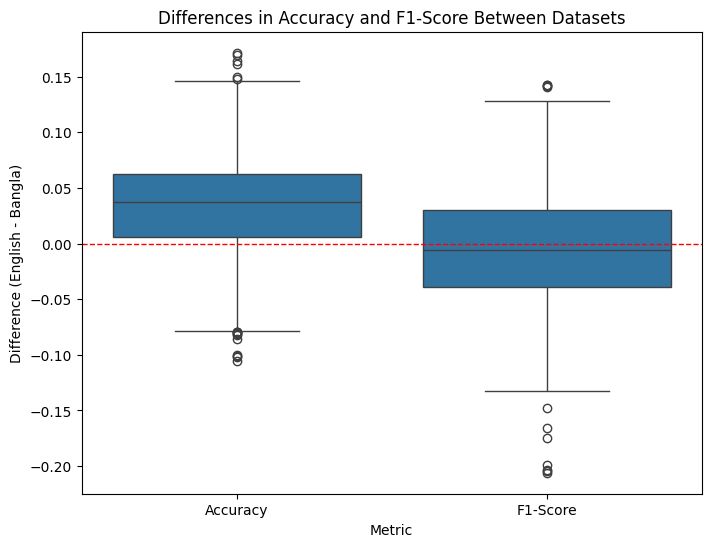

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Example data: differences in accuracy and F1-scores
# accuracy_differences =  [0.0141, 0.0008, 0.057, 0.0106, 0.0029, 0.0171, 0.016, 0.0232, 0.0422, 0.0269, 0.0466, 0.0411, 0.006, 0.0368, 0.0426, 0.0375]
# f1_differences = [-0.0213, -0.04, 0.0358, 0.0099, 0.0034, -0.0017, -0.013, -0.0067, 0.0074, -0.028, 0.0404, 0.0405, 0.0073, -0.002, 0.0357, 0.0102]

# Combine data into a DataFrame for plotting
import pandas as pd
data = pd.DataFrame({
    'Difference': accuracy_differences + f1_differences,
    'Metric': ['Accuracy'] * len(accuracy_differences) + ['F1-Score'] * len(f1_differences)
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Metric', y='Difference', data=data)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
# Set title and labels with larger font sizes
plt.title('Differences in Accuracy and F1-Score Between Datasets', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Difference (English - Bangla)', fontsize=14)


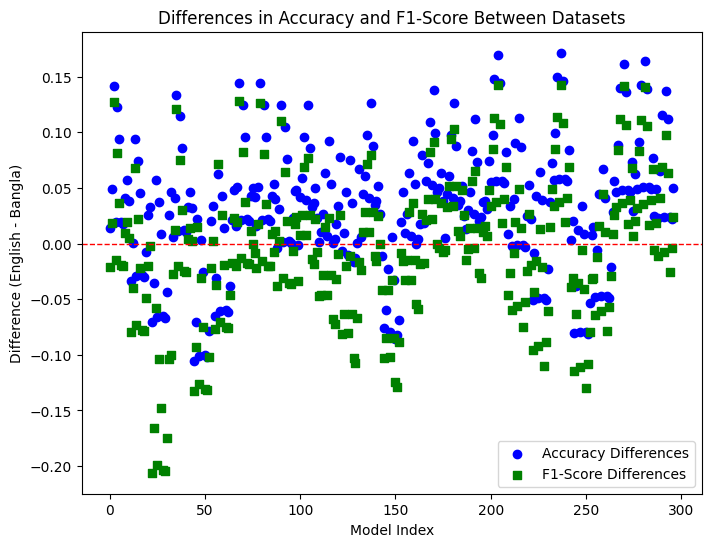

In [ ]:
plt.figure(figsize=(8, 6))

# Scatter plot for accuracy differences
plt.scatter(range(len(accuracy_differences)), accuracy_differences, color='blue', label='Accuracy Differences', marker='o')

# Scatter plot for F1-score differences
plt.scatter(range(len(f1_differences)), f1_differences, color='green', label='F1-Score Differences', marker='s')

# Plot settings
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Reference line at 0
plt.title('Differences in Accuracy and F1-Score Between Datasets')
plt.xlabel('Model Index')
plt.ylabel('Difference (English - Bangla)')
plt.legend()
plt.show()
